In [17]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.sparse
from sklearn.model_selection import train_test_split
import os
import re
import time
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, make_scorer, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


# Introduction

Below are data preprocessing performed already in EDA. We are preparing the data for modeling purposes. We would like to break down the process as following:

* Data preprocessing (basic data clean performed during EDA)

* Variable importance/ feature selection

* Principal component analysis

Since many drug prescription numbers can go up to thousands, it is best to scale the data and compare the model performance. We will assess whether scaling matters when the difference between min and max are in thousands.

* Train-Test Split

* Standard Scale

* MinMaxScaler

* MaxAbsScaler

After data preprocessing, 

* logistic regression (top 30 variables vs pca)

* SVM (top 30 variables vs pca)

* KNN (top 30 variables vs pca)

* Random Forest (top 30 variables vs pca)

* XGBoost (top 30 variables vs pca)


# Data preprocessing

Below preprocessing steps have already been performed in Exploratory Data Analysis. These steps were deemed to be best methods of choosing for building models after some exploration.

* Make drug names consistent across the board for data columns
* Exclude US territories but keep District of Columbia and 50 states
* Merge different ways to name specialties. Exclude "others" since specialty counts < 10 were deemd insignificant for not having enough sample sizes. Upon analysis of "others", it was a mixed bad and did not have much to interpret either.

In [18]:
# import data as csv files
df = pd.read_csv('prescriber-info.csv')
opioids = pd.read_csv('opioids.csv')

#List of drugnames overall
drug_names_overall = df.columns[5:-1]

# replace spaces and hypens with periods
opioids["Drug Name"] = opioids["Drug Name"].replace('-', '.', regex=True)
opioids["Drug Name"] = opioids["Drug Name"].replace(' ', '.', regex=True)

# Exclude US territories. Only include 50 states and DC
tables = pd.read_html(r'https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes') # get list of state abbreviations
states = tables[0]['Postal Code'] # 51 entries, including DC
df['State'] = np.where(df['State'].isin(states), df['State'], 'Other')
df = df[~df.State.str.contains('Other')] #include DC but exclude PR, VI, ZZ, AE, GU, AA # 24759 rows

# clean specialty values
df.loc[df['Specialty'].str.contains('Nurse'), 'Specialty'] = 'Nurse'
df.loc[df['Specialty'].str.contains('rectal', case=False), 'Specialty'] = 'Colorectal Surgery'
df.loc[df['Specialty'].str.contains('Physical'), 'Specialty'] = 'Physical Medicine'
df.loc[df['Specialty'].str.contains('Psychologist'), 'Specialty'] = 'Psychologist'
df.loc[df['Specialty'].str.contains('Pain'), 'Specialty'] = 'Pain Management'
df.loc[df['Specialty'].str.contains('Cardiac'), 'Specialty'] = 'Cardiology'
df.loc[df['Specialty'].str.contains('Oncology'), 'Specialty'] = 'Oncology'
df.loc[df['Specialty'].str.contains('Psychiatry', case=False), 'Specialty'] = 'Psychiatry'
df.loc[df['Specialty'].str.contains('Radiology'), 'Specialty'] = 'Radiology'
df.loc[df['Specialty'].str.contains('neuro', case=False), 'Specialty'] = 'Neurology'
df.loc[df['Specialty'].str.contains('Oral'), 'Specialty'] = 'Oral Surgery'
df.loc[df['Specialty'].str.contains('Radiology'), 'Specialty'] = 'Radiology'
df.loc[df['Specialty'].str.contains('Sports'), 'Specialty'] = 'Physical Medicine'
df['Specialty'] = df['Specialty'].replace(['Family Practice', 'Plastic and Reconstructive Surgery', 'Orthopaedic Surgery'], 
                                          ['Family Medicine', 'Plastic Surgery', 'Orthopedic Surgery'])
df.loc[df.groupby('Specialty').Specialty.transform('count').lt(10), 'Specialty'] = 'Other'
df = df[~df.Specialty.str.contains('Other')]
df.loc[df['Specialty'] == 'Student in an Organized Health Care Education/Training Program', 'Specialty'] \
= 'Medical Students, Interns, Residents'
#df['Specialty'].value_counts()

# Drop NPI (identification for each prescriber) and Credentials (since we will be using specialty instead)
df = df.drop(['NPI','Credentials'], axis = 1)
df = pd.get_dummies(df, columns = ['Gender','State','Specialty'])

In [19]:
X = df.copy()
X = X.drop(['Opioid.Prescriber'], axis = 1)
Y = df['Opioid.Prescriber']

In [20]:
X

,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,...,Specialty_Podiatry,Specialty_Preventive Medicine,Specialty_Psychiatry,Specialty_Pulmonary Disease,Specialty_Radiology,Specialty_Rheumatology,Specialty_Specialist,Specialty_Thoracic Surgery,Specialty_Urology,Specialty_Vascular Surgery
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,134,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,43,0,0,0,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,19,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,12,0,0,0,46,25,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24996,0,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,0,0,0,0,0,0,0,16,0,0,...,0,0,0,0,0,0,0,0,0,0


## Scaling and finding optimal splits

In [6]:
# Define the values to test for train_test_split
test_sizes = [0.2, 0.3, 0.5]

# Define the scaling techniques to test
scalers = [None, StandardScaler(), MinMaxScaler(), MaxAbsScaler()]

for test_size in test_sizes:
    
    for scaler in scalers:
        
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
        
        if scaler is None:
            X_train_scaled = X_train
            X_test_scaled = X_test
        else:
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.fit_transform(X_test)
        
        clf_rf = RandomForestClassifier(random_state = 0,oob_score=True, n_jobs = -1)
        clf_rf = clf_rf.fit(X_train_scaled,Y_train)
        
        print("Test Size:", test_size)
        print("Scaler:", scaler if scaler is not None else "None")

        rf_accuracy_train = clf_rf.score(X_train_scaled,Y_train)
        rf_accuracy_test = clf_rf.score(X_test_scaled,Y_test)
        
        print("This is the training accuracy", rf_accuracy_train)
        print("This is the test accuracy", rf_accuracy_test)
        print("This is the OOB score",clf_rf.oob_score_)
        print("--------------------")

Test Size: 0.2
Scaler: None
This is the training accuracy 0.9986830775464721
This is the test accuracy 0.9167341977309562
This is the OOB score 0.9224028769690523
--------------------
Test Size: 0.2
Scaler: StandardScaler()
This is the training accuracy 0.9986830775464721
This is the test accuracy 0.9155186385737439
This is the OOB score 0.9224028769690523
--------------------
Test Size: 0.2
Scaler: MinMaxScaler()
This is the training accuracy 0.9986830775464721
This is the test accuracy 0.9161264181523501
This is the OOB score 0.9222002735146634
--------------------
Test Size: 0.2
Scaler: MaxAbsScaler()
This is the training accuracy 0.9986830775464721
This is the test accuracy 0.9161264181523501
This is the OOB score 0.9222002735146634
--------------------
Test Size: 0.3
Scaler: None
This is the training accuracy 0.9988422575976845
This is the test accuracy 0.9184224743381956
This is the OOB score 0.9227785817655572
--------------------
Test Size: 0.3
Scaler: StandardScaler()
This is 

Test Size of 0.3 with scalers MinMaxScaler() and MaxAbsScaler() came out to have the best results. Because the max value of all columns was in thousands and the minimum was zero, scaling did not have that much of an effect. This also explains why MaxAbs scaler and MinMax scaler yielded same results across the board.

* We will use test_size of 0.3 for now and test the performance of MinMaxScaler() with None and PCA in the future.

In [21]:
# In the future, we will use X_train, X_train_scaled (MinMaxScaler()), and X_pca (after we perform it)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train_scaled = MinMaxScaler().fit_transform(X_train)
X_test_scaled = MinMaxScaler().fit_transform(X_test)


## Principal Component Analysis

177 is the total number of components to retain 85% of variance
(17275, 177)
(7404, 177)


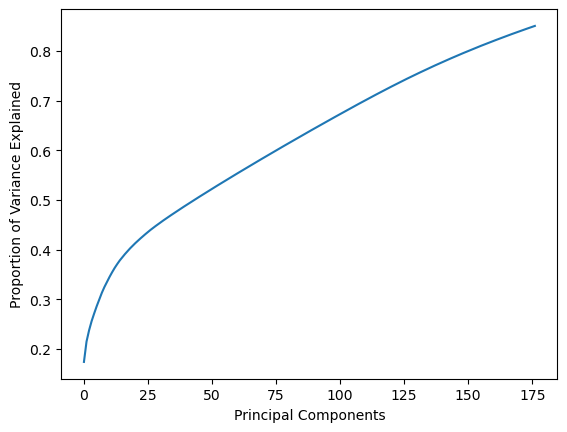

In [22]:
#PCA for exploratory analysis and picking important variables using PCA

df_PCA = df.copy()
opioids_to_remove = list(set(opioids['Drug Name']) & set(df.columns.tolist()))
X_PCA = X.copy()
X_PCA = X_PCA[X_PCA.columns.difference(opioids_to_remove)]
Y_PCA = Y.copy()

X_train_PCA, X_test_PCA, Y_train_PCA, Y_test_PCA = train_test_split(X_PCA, Y_PCA, test_size=0.3, random_state=42)

# Scale already split data for PCA analysis
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train_PCA)

# Apply transform to both the training set and the test set.
X_train_PCA = scaler.transform(X_train_PCA)
X_test_PCA = scaler.transform(X_test_PCA)

# Make an instance of the Model 
pca = PCA(n_components=0.85) #needs 177 components to retain 85% of variance
#fit PCA on training set
pca.fit(X_train_PCA)

variance = pca.explained_variance_ratio_

print(pca.n_components_, "is the total number of components to retain 85% of variance")

plt.plot(np.cumsum(variance))
plt.xlabel('Principal Components')
plt.ylabel('Proportion of Variance Explained')


X_train_pca = pca.transform(X_train_PCA) ### USE THIS
X_test_pca = pca.transform(X_test_PCA) ### USE THIS

print(X_train_pca.shape)
print(X_test_pca.shape)

PCA was only able to reduce the number of components down to 177 to retain 85% of variability from 354 variables retaining 100% of variability. We would have to test how PCA data compares with the data with ~30 important variables.

## Variable Importance Analysis

### Hypertune RF to get the variable importance for the best performing RF

We will loop across number of trees and number of features to split on for building of random forest. The best performing combination will be chosen.

In [9]:
# these model takes forever to run. Look at below list for results

rf_num_trees = np.arange(1,1101,50)

#400 is best - this model takes forever to run
store_error = list()
for n_tree in rf_num_trees:
    clf_rf = RandomForestClassifier(n_estimators = n_tree, random_state = 42, n_jobs = -1)
    clf_rf = clf_rf.fit(X_train_scaled,Y_train)
    rf_accuracy = clf_rf.score(X_test_scaled,Y_test)
    store_error.append(1-rf_accuracy)
print(store_error)
#[0.15059427336574827, 0.08292814694759587, 0.08292814694759587, 0.08103727714748787, 0.08036196650459215, 0.07968665586169643, 0.07995678011885465, 0.07982171799027549, 0.0794165316045381, 0.07928146947595893, 0.07968665586169643, 0.07968665586169643, 0.0794165316045381, 0.07995678011885465, 0.07982171799027549, 0.08036196650459215, 0.08009184224743382, 0.07982171799027549, 0.07968665586169643, 0.0794165316045381, 0.07995678011885465, 0.08022690437601299]

[0.15059427336574827, 0.08292814694759587, 0.08292814694759587, 0.08103727714748787, 0.08036196650459215, 0.07968665586169643, 0.07995678011885465, 0.07982171799027549, 0.0794165316045381, 0.07928146947595893, 0.07968665586169643, 0.07968665586169643, 0.0794165316045381, 0.07995678011885465, 0.07982171799027549, 0.08036196650459215, 0.08009184224743382, 0.07982171799027549, 0.07968665586169643, 0.0794165316045381, 0.07995678011885465, 0.08022690437601299]


In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(rf_num_trees, store_error, label = 'Random Forest')
plt.legend()
plt.title('Test Error Comparision')
plt.xlabel('n_trees in Random Forest')
plt.ylabel('test error')


<div>
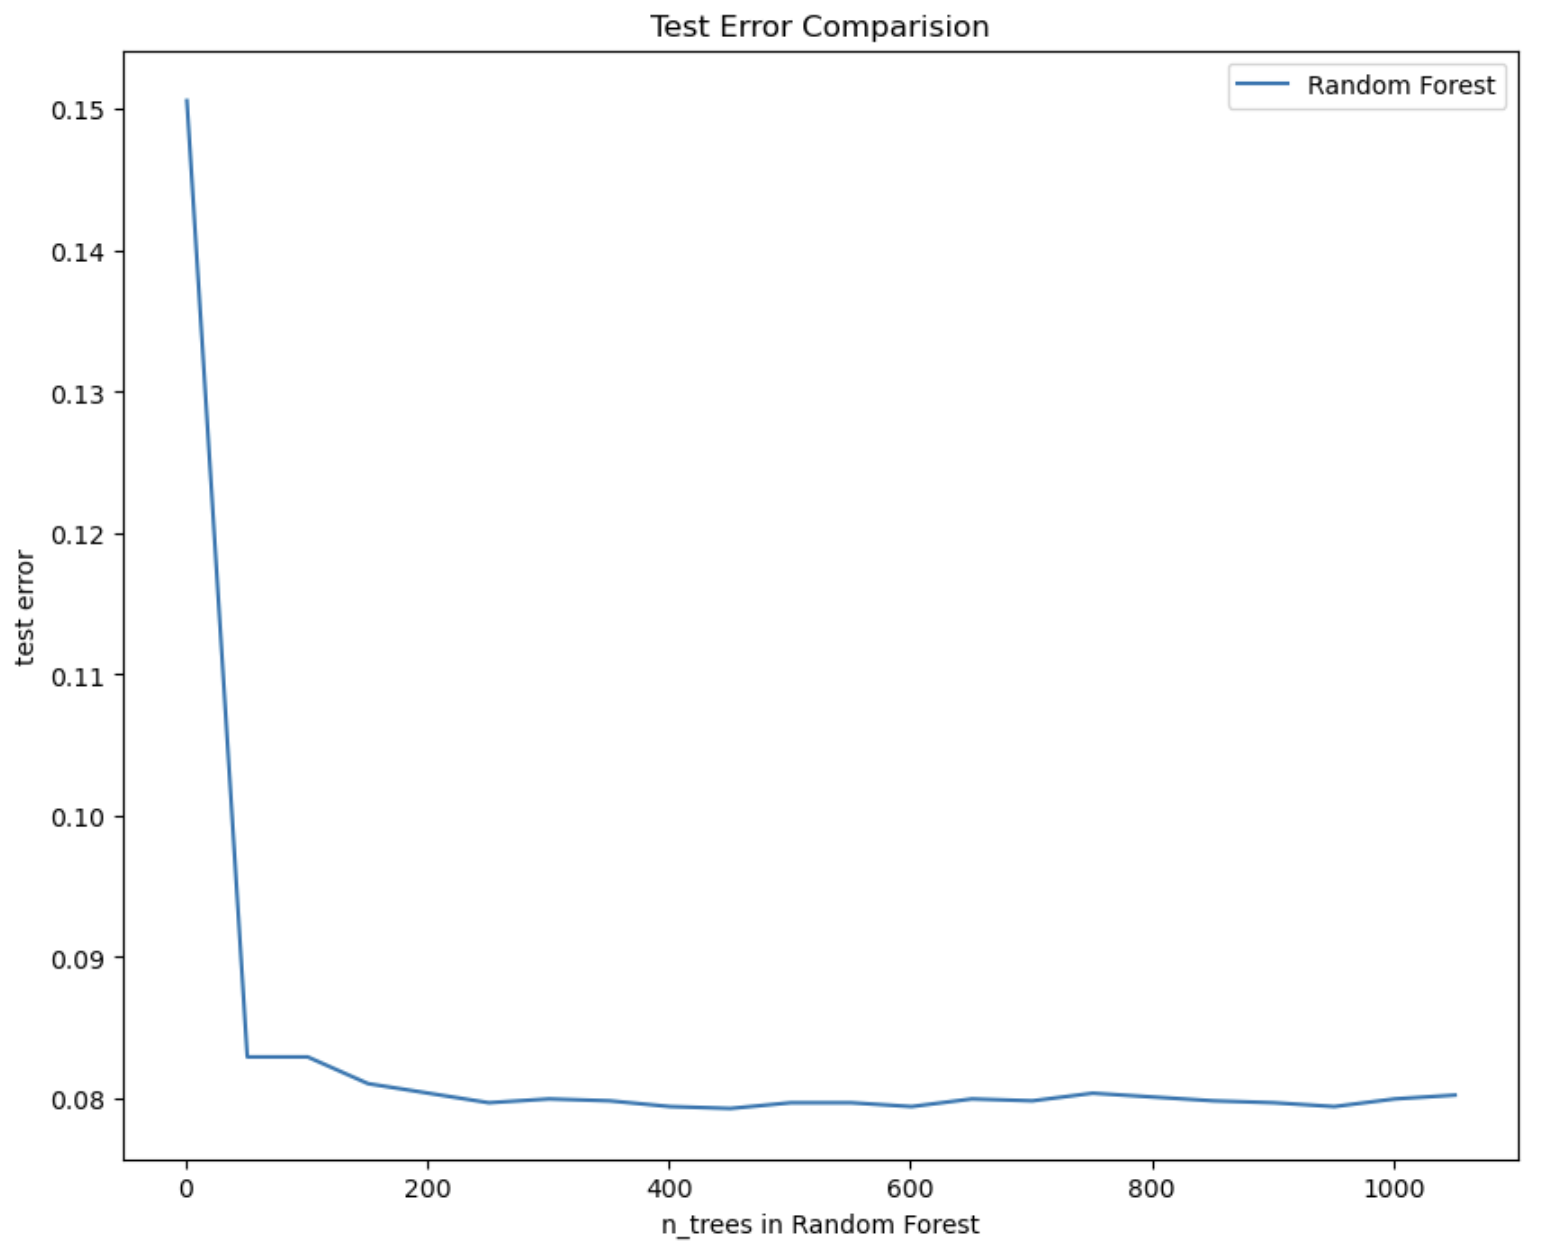
</div>


In [19]:
#create lists for Test Error and OOB Error
store_errors_maxfeatures = list()
store_oob = list()

#Create tuning variable for parameter max_features
n_features_to_split = np.arange(0,X_train_scaled.shape[1]+1,15)[1:]
print(n_features_to_split)

[ 15  30  45  60  75  90 105 120 135 150 165 180 195 210 225 240 255 270
 285 300 315 330 345]


In [20]:
for n_features in n_features_to_split:
    clf_rf = RandomForestClassifier(n_estimators = 400, max_features=n_features,random_state = 42,oob_score=True, n_jobs=-1)
    clf_rf = clf_rf.fit(X_train_scaled,Y_train)
    rf_accuracy = clf_rf.score(X_test_scaled,Y_test)
    store_errors_maxfeatures.append(1-rf_accuracy)
    store_oob.append(1- clf_rf.oob_score_)
print("model is finished")

model is finished


In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(n_features_to_split, store_errors_maxfeatures, label = 'RF Test Error')
ax.plot(n_features_to_split, store_oob, label = 'RF OOB Error')
plt.legend()
plt.title('Error Comparisions, max_features vs OOB & Test Errors')
plt.xlabel('n_features_to_split in Random Forest')
plt.ylabel('OOB/Test Errors')

#max features of 18 seems best


<div>
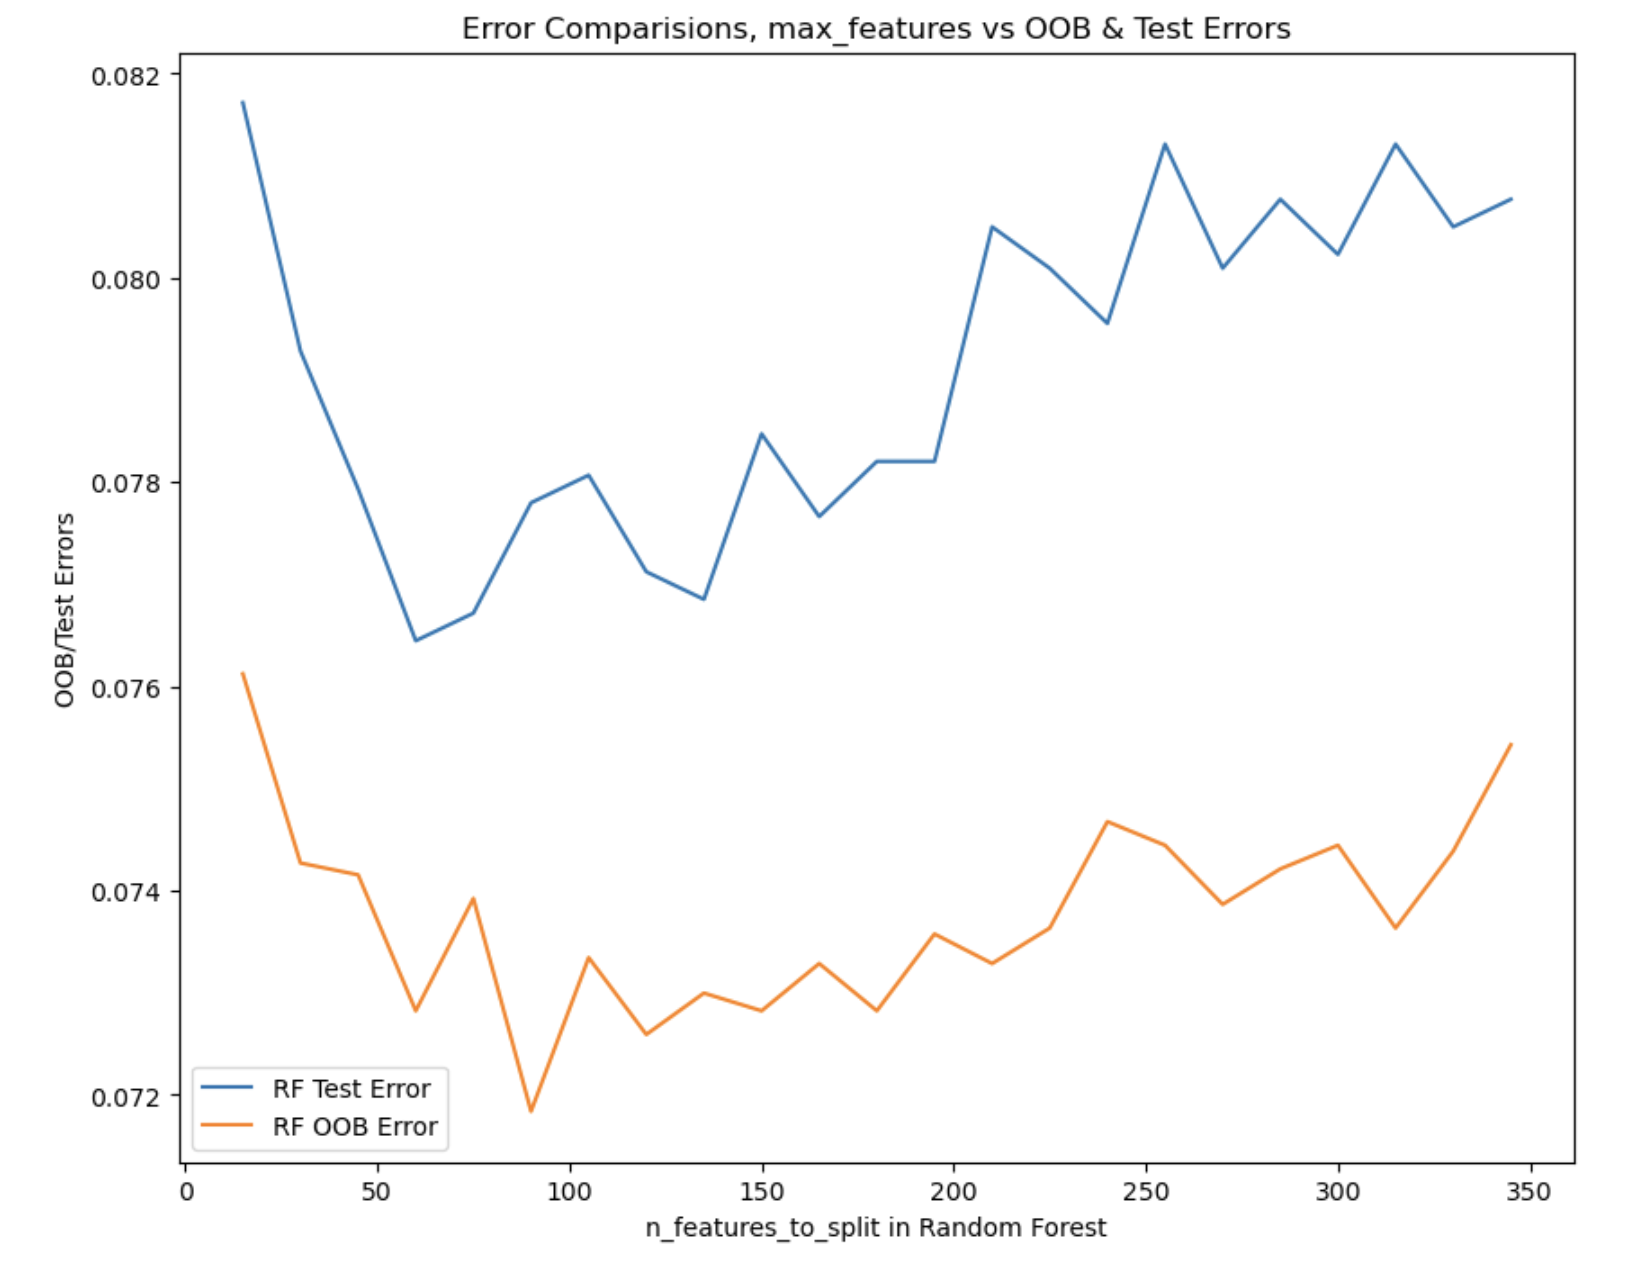
</div>


Looks like n_features_to_split of 60 and n_estimators of 400 will perform the best. We will choose 400 for now. 

In [23]:
# perform feature selection with optimized random forest to see which variables are important
# Remove opioids from this particular dataset and see varimp
opioids_to_remove = list(set(opioids['Drug Name']) & set(df.columns.tolist()))
X_varimp = df.copy()
X_varimp = X_varimp[X_varimp.columns.difference(opioids_to_remove)]
X_varimp = X_varimp.drop(['Opioid.Prescriber'], axis = 1)
Y_varimp = df['Opioid.Prescriber']

X_train_imp, X_test_imp, Y_train, Y_test = train_test_split(X_varimp, Y_varimp, test_size=0.3, random_state=42)    
X_train_scaled_imp = MinMaxScaler().fit_transform(X_train_imp)
X_test_scaled_imp = MinMaxScaler().fit_transform(X_test_imp)
X_train_scaled = pd.DataFrame(X_train_scaled_imp, columns = X_varimp.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_imp, columns = X_varimp.columns)


0.825634792004322
0.8341534008683068



Text(0.5, 1.0, 'Top 30 Random Forest Feature Importance without Opioids')

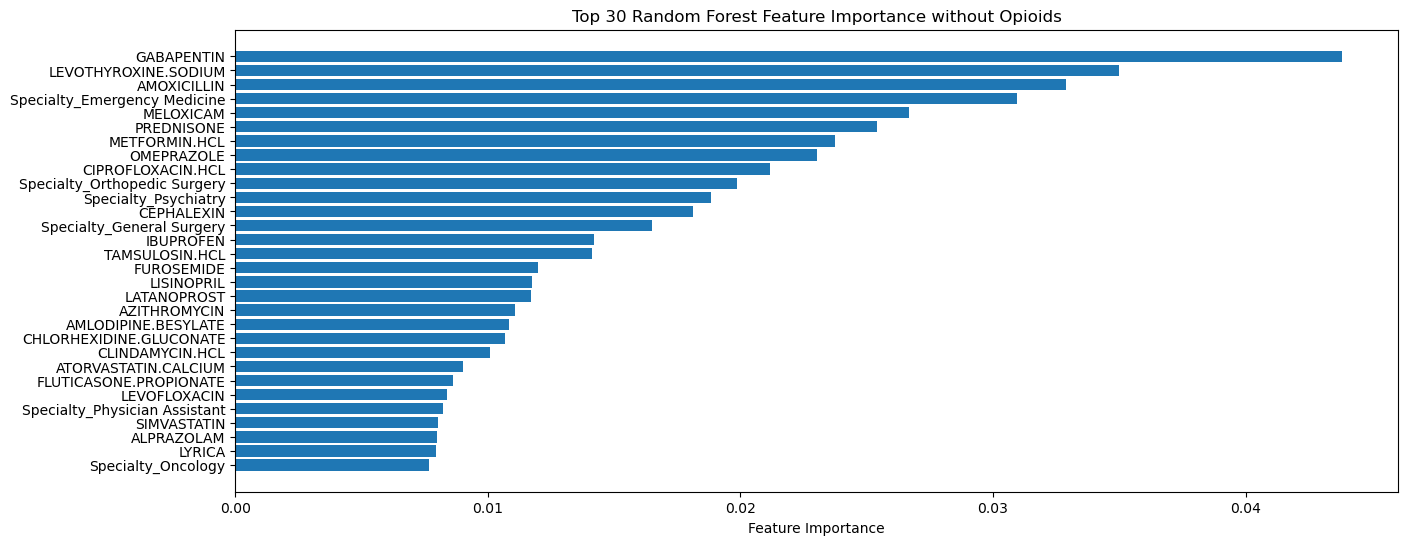

In [24]:
clf_rf = RandomForestClassifier(n_estimators = 400, max_features=60,random_state = 42,oob_score=True, n_jobs = -1)
clf_rf = clf_rf.fit(X_train_scaled_imp,Y_train)
rf_accuracy = clf_rf.score(X_test_scaled_imp,Y_test)
print(rf_accuracy)
print(clf_rf.oob_score_)
sort = clf_rf.feature_importances_.argsort()[-30:]
descending_order = list(X_varimp.columns[sort][::-1])

print()

fig, ax = plt.subplots()
fig.set_size_inches( 15, 6)
plt.barh(X_varimp.columns[sort], clf_rf.feature_importances_[sort])
plt.xlabel("Feature Importance")
plt.title('Top 30 Random Forest Feature Importance without Opioids')



In [25]:
RF_top30 = list(X_varimp.columns[sort][::-1])
print(RF_top30)

['GABAPENTIN', 'LEVOTHYROXINE.SODIUM', 'AMOXICILLIN', 'Specialty_Emergency Medicine', 'MELOXICAM', 'PREDNISONE', 'METFORMIN.HCL', 'OMEPRAZOLE', 'CIPROFLOXACIN.HCL', 'Specialty_Orthopedic Surgery', 'Specialty_Psychiatry', 'CEPHALEXIN', 'Specialty_General Surgery', 'IBUPROFEN', 'TAMSULOSIN.HCL', 'FUROSEMIDE', 'LISINOPRIL', 'LATANOPROST', 'AZITHROMYCIN', 'AMLODIPINE.BESYLATE', 'CHLORHEXIDINE.GLUCONATE', 'CLINDAMYCIN.HCL', 'ATORVASTATIN.CALCIUM', 'FLUTICASONE.PROPIONATE', 'LEVOFLOXACIN', 'Specialty_Physician Assistant', 'SIMVASTATIN', 'ALPRAZOLAM', 'LYRICA', 'Specialty_Oncology']


In [26]:
sorting_by_importance = clf_rf.feature_importances_.argsort()
all_imp_variables_desc = list(X_varimp.columns[sorting_by_importance][::-1])


print("The top 15 variables when you take out opioids are:", all_imp_variables_desc[:15])
print()
important_nonopioids_variables = [(i, var) for (i, var) in enumerate(descending_order) if var in drug_names_overall]
print("These are the important variables in descending order",important_nonopioids_variables[:10])
print()
important_specialty = [(i, specialty) for (i, specialty) in enumerate(all_imp_variables_desc) if specialty not in set(opioids['Drug Name']) and 'Specialty' in specialty]
print("Imporant speciaties are: ", important_specialty[:10])
print()
important_state = [(i, state) for (i, state) in enumerate(all_imp_variables_desc) if state not in set(opioids['Drug Name']) and 'State' in state]
print("Imporant states are: ", important_state[:10])
print()
important_gender = [(i, gender) for (i, gender) in enumerate(all_imp_variables_desc) if gender not in set(opioids['Drug Name']) and 'Gender' in gender]
print("Imporant genders are: ", important_gender[:10])

The top 15 variables when you take out opioids are: ['GABAPENTIN', 'LEVOTHYROXINE.SODIUM', 'AMOXICILLIN', 'Specialty_Emergency Medicine', 'MELOXICAM', 'PREDNISONE', 'METFORMIN.HCL', 'OMEPRAZOLE', 'CIPROFLOXACIN.HCL', 'Specialty_Orthopedic Surgery', 'Specialty_Psychiatry', 'CEPHALEXIN', 'Specialty_General Surgery', 'IBUPROFEN', 'TAMSULOSIN.HCL']

These are the important variables in descending order [(0, 'GABAPENTIN'), (1, 'LEVOTHYROXINE.SODIUM'), (2, 'AMOXICILLIN'), (4, 'MELOXICAM'), (5, 'PREDNISONE'), (6, 'METFORMIN.HCL'), (7, 'OMEPRAZOLE'), (8, 'CIPROFLOXACIN.HCL'), (11, 'CEPHALEXIN'), (13, 'IBUPROFEN')]

Imporant speciaties are:  [(3, 'Specialty_Emergency Medicine'), (9, 'Specialty_Orthopedic Surgery'), (10, 'Specialty_Psychiatry'), (12, 'Specialty_General Surgery'), (25, 'Specialty_Physician Assistant'), (29, 'Specialty_Oncology'), (35, 'Specialty_Optometry'), (46, 'Specialty_Dentist'), (51, 'Specialty_Oral Surgery'), (58, 'Specialty_Nurse')]

Imporant states are:  [(33, 'State_NY'

### Hypertune XGBoost to get the variable importance for the best performing XGBoost

The codes in the below section was run in Google Colab because it took too long to run in my macbook

In [ ]:
start_time = time.time()
clf_xgb = XGBClassifier(objective='binary:logistic', n_estimators=500, seed=42, early_stopping_rounds=50, eval_metric='auc', n_jobs=-1)
clf_xgb = clf_xgb.fit(X_train_scaled, Y_train, eval_set=[(X_test_scaled, Y_test)], verbose=False) 
print(clf_xgb.best_ntree_limit)
print("--- %s seconds ---" % (time.time() - start_time))

88

--- 38.76919341087341 seconds ---

In [ ]:
y_pred_xgb = clf_xgb.predict(X_test_scaled)
acc_xgb = round(accuracy_score(Y_test, y_pred_xgb),3)
pr_xgb = round(precision_score(Y_test, y_pred_xgb), 3)
recall_xgb = round(recall_score(Y_test, y_pred_xgb), 3)
f1_xgb = round(f1_score(Y_test, y_pred_xgb), 3)
auc_xgb = round(roc_auc_score(Y_test, y_pred_xgb),3)
print(acc_xgb, pr_xgb, recall_xgb, f1_xgb, auc_xgb)
# 0.836 0.869 0.844 0.857 0.834


0.836 0.869 0.844 0.857 0.834


In [ ]:
# use gridsearchcv using base data
param_grid = {
    'max_depth': [6],
    'learning_rate': [0.15, 0.2, 0.25, 0.3, 0.35],
    'gamma': [0.1, 0.15, 0.2, 0.25],
    'reg_lambda': [0.04, 0.05, 0.06, 0.07],
    'n_estimators': [50, 70, 90, 110]
}
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', # to prevent overfitting, we only use a random 80% subset of the data and a random 50% subset of the features per tree
                              seed=42, subsample=0.8, colsample_bytree=0.5),
                              param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv=5)
optimal_params.fit(X_train_scaled, Y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test_scaled, Y_test)], verbose=False)
print(optimal_params.best_params_)

optimal parameters are:
{'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 110, 'reg_lambda': 0.04}

In [ ]:
# run optimised model with above parameters
xgboost = xgb.XGBClassifier(objective='binary:logistic', n_estimators=110,
                          seed=42, subsample=0.9, colsample_bytree=0.5,
                          max_depth=6, learning_rate=0.15, gamma=0.1, reg_lambda=0.04,
                          early_stopping_rounds=10, eval_metric='auc'
                           )
xgboost.fit(X_train_scaled, Y_train, eval_set=[(X_test_scaled, Y_test)], verbose=False)
y_pred_xgb = xgboost.predict(X_test_scaled)
acc_xgb = round(accuracy_score(Y_test, y_pred_xgb), 3)
pr_xgb = round(precision_score(Y_test, y_pred_xgb), 3)
recall_xgb = round(recall_score(Y_test, y_pred_xgb), 3)
f1_xgb = round(f1_score(Y_test, y_pred_xgb), 3)
auc_xgb = round(roc_auc_score(Y_test, y_pred_xgb),3)
# print(classification_report(Y_test, y_pred_xgb, target_names=['Infrequent prescriber', 'Frequent prescriber']))
print(acc_xgb, pr_xgb, recall_xgb, f1_xgb, auc_xgb)


0.834 0.869 0.841 0.855 0.833

In [ ]:
# plot important features to visualize which features stand out
xgb.plot_importance(xgboost, max_num_features = 31)
plt.rcParams['figure.figsize'] = [14, 12]
plt.show()


<div>
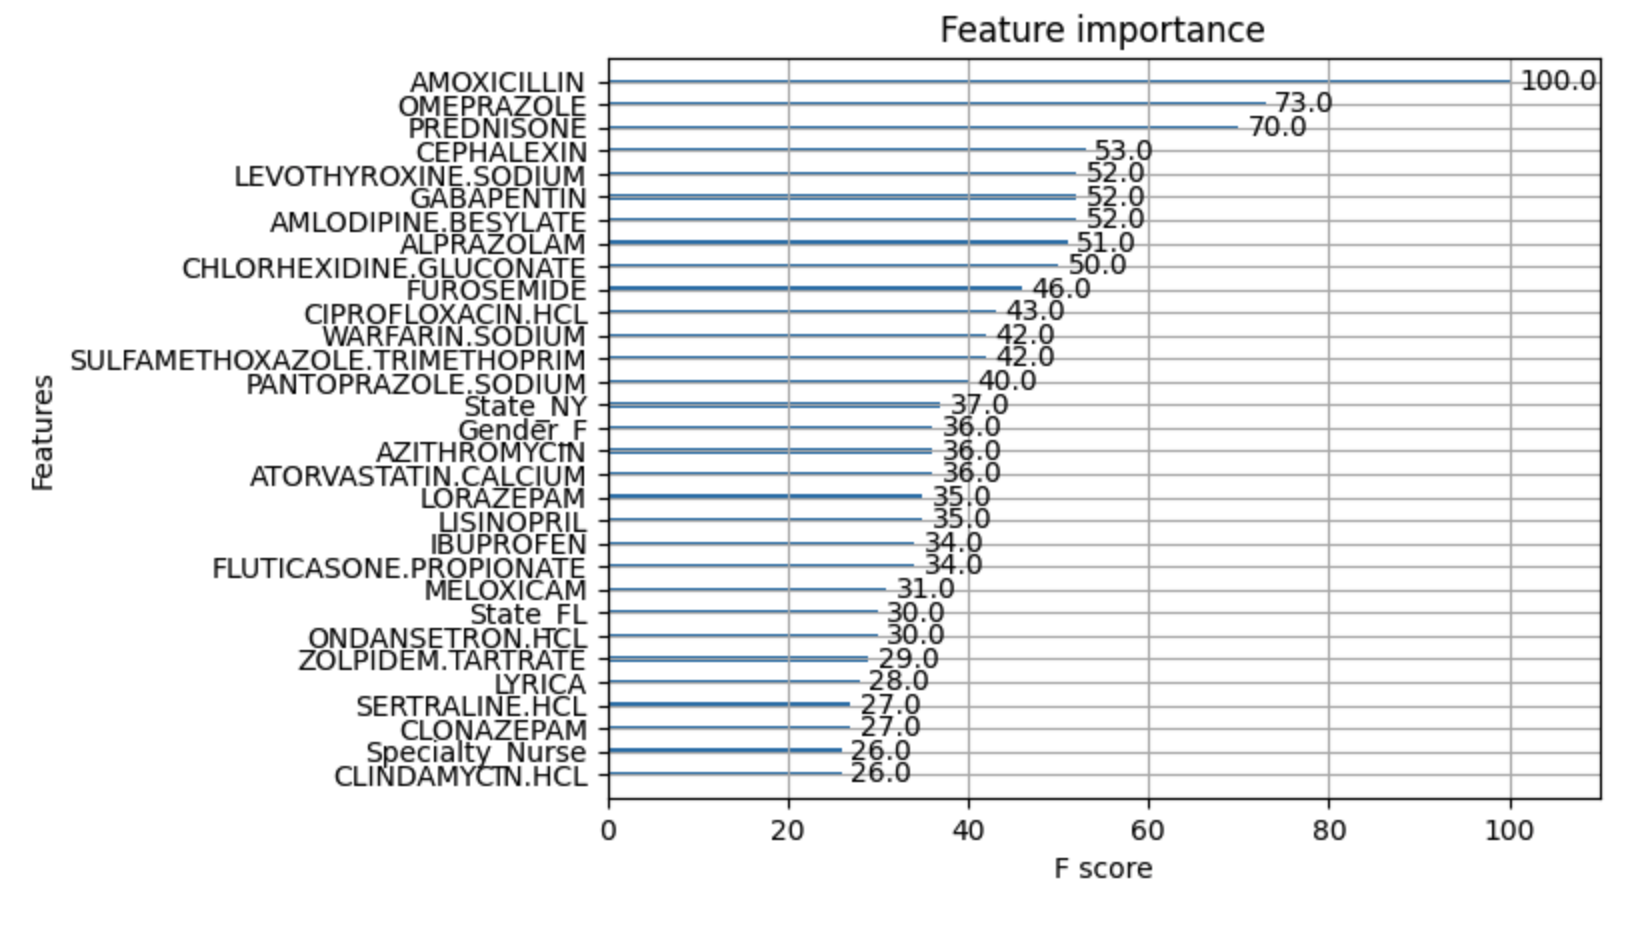
</div>


In [ ]:
xgb_top = xgboost.get_booster().get_score(importance_type='weight')
xgb_topfeat = sorted(xgb_top, key=xgb_top.get, reverse=True)[:30]

xgb_topfeat = 
['AMOXICILLIN',
 'OMEPRAZOLE',
 'PREDNISONE',
 'CEPHALEXIN',
 'AMLODIPINE.BESYLATE',
 'GABAPENTIN',
 'LEVOTHYROXINE.SODIUM',
 'ALPRAZOLAM',
 'CHLORHEXIDINE.GLUCONATE',
 'FUROSEMIDE',
 'CIPROFLOXACIN.HCL',
 'SULFAMETHOXAZOLE.TRIMETHOPRIM',
 'WARFARIN.SODIUM',
 'PANTOPRAZOLE.SODIUM',
 'State_NY',
 'ATORVASTATIN.CALCIUM',
 'AZITHROMYCIN',
 'Gender_F',
 'LISINOPRIL',
 'LORAZEPAM',
 'FLUTICASONE.PROPIONATE',
 'IBUPROFEN',
 'MELOXICAM',
 'ONDANSETRON.HCL',
 'State_FL',
 'ZOLPIDEM.TARTRATE',
 'LYRICA',
 'CLONAZEPAM',
 'SERTRALINE.HCL',
 'CLINDAMYCIN.HCL']

In [27]:
# top 30 from XGBoost
xgb_topfeat = ['AMOXICILLIN', 'OMEPRAZOLE', 'PREDNISONE', 'CEPHALEXIN', 'AMLODIPINE.BESYLATE', 'GABAPENTIN', 'LEVOTHYROXINE.SODIUM', 'ALPRAZOLAM', 'CHLORHEXIDINE.GLUCONATE', 'FUROSEMIDE', 'CIPROFLOXACIN.HCL', 'SULFAMETHOXAZOLE.TRIMETHOPRIM', 'WARFARIN.SODIUM', 'PANTOPRAZOLE.SODIUM', 'State_NY', 'ATORVASTATIN.CALCIUM', 'AZITHROMYCIN', 'Gender_F', 'LISINOPRIL', 'LORAZEPAM', 'FLUTICASONE.PROPIONATE', 'IBUPROFEN', 'MELOXICAM', 'ONDANSETRON.HCL', 'State_FL', 'ZOLPIDEM.TARTRATE', 'LYRICA', 'CLONAZEPAM', 'SERTRALINE.HCL', 'CLINDAMYCIN.HCL']
print("The union of RF important variables and XGBoost important variable totaled to a sum:", len(set(xgb_topfeat).union(set(RF_top30))))

The union of RF important variables and XGBoost important variable totaled to a sum: 41


In [28]:
final_columns = list(set(xgb_topfeat).union(set(RF_top30)))

X_train_xgb_rf = X_train_scaled[final_columns]
X_test_xgb_rf = X_test_scaled[final_columns]

In [29]:
X_train_xgb_rf

,WARFARIN.SODIUM,ALPRAZOLAM,LORAZEPAM,ATORVASTATIN.CALCIUM,CLONAZEPAM,Specialty_Orthopedic Surgery,AZITHROMYCIN,State_NY,PREDNISONE,SIMVASTATIN,...,Specialty_Psychiatry,AMOXICILLIN,Gender_F,State_FL,MELOXICAM,ONDANSETRON.HCL,Specialty_Oncology,LEVOTHYROXINE.SODIUM,Specialty_General Surgery,OMEPRAZOLE
0,0.007630,0.010499,0.046739,0.029760,0.028853,0.0,0.019231,0.0,0.008576,0.068009,...,0.0,0.037118,0.0,0.0,0.000000,0.049327,0.0,0.011818,0.0,0.027743
1,0.000000,0.000000,0.000000,0.024381,0.000000,0.0,0.000000,0.0,0.000000,0.008501,...,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.025758,0.0,0.008197
2,0.004810,0.000000,0.000000,0.050556,0.000000,0.0,0.000000,0.0,0.000000,0.038926,...,0.0,0.056769,0.0,0.0,0.000000,0.000000,0.0,0.029091,0.0,0.051072
3,0.002820,0.000000,0.000000,0.000000,0.000000,0.0,0.030769,0.0,0.049547,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.011980
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17270,0.005639,0.000000,0.000000,0.021872,0.000000,0.0,0.000000,0.0,0.000000,0.009396,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
17271,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.065502,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
17272,0.000000,0.022572,0.029348,0.013266,0.016890,0.0,0.000000,0.0,0.000000,0.041163,...,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.016970,0.0,0.034048
17273,0.000000,0.000000,0.000000,0.009322,0.000000,0.0,0.000000,0.0,0.010005,0.012081,...,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.005758,0.0,0.010088


Here are the preprocessed datasets to run our models:

For Variable Importance reduced datasets:

Union of Random Forest & XGBoost:
* X_train_xgb_rf / Y_train
* X_test_xgb_rf / Y_test


For PCA dimensionality reduced datasets:
* X_train_pca / Y_train_PCA
* X_test_pca / Y_test_PCA

## GAME PLAN FOR THIS PROJECT

4. TRAIN AND TEST AGAINST COMBINED DATA VS PCA FOR BELOW MODELS
5. MAKE CHANGES AS NEEDED TO README.MD

# Logistic Regression

In [ ]:
# Run logistic regression with top 41 variables from random forest & XGBoost
# 30 variables model - MaxMinScaler data without opioids - X_train_xgb_rf, X_test_xgb_rf, Y_train, Y_test
# param_grid = {'solver': ['lbfgs', 'saga', 'liblinear'], 'penalty': ['none','l1','l2','elasticnet'],'Cs': [100, 10, 1.0, 0.1, 0.01]}

param_grid = {'solver': ['lbfgs', 'saga', 'liblinear'],'Cs': [500, 100, 10, 1]}

grid = GridSearchCV(LogisticRegressionCV(max_iter=10000, random_state=42, n_jobs=-1), param_grid, scoring='roc_auc', refit=True, verbose=1)
grid.fit(X_train_xgb_rf, Y_train)

Y_pred_logreg_base = grid.predict(X_test_xgb_rf)

#Check accuracy, precision, recall, f1, auc
print(grid.best_params_)

acc_logr = round(grid.best_score_, 3)
pr_logr = round(precision_score(Y_test, Y_pred_logreg_base), 3)
recall_logr = round(recall_score(Y_test, Y_pred_logreg_base), 3)
f1_logr = round(f1_score(Y_test, Y_pred_logreg_base), 3)
auc_logr = round(roc_auc_score(Y_test, Y_pred_logreg_base),3)

print(acc_logr, pr_logr, recall_logr, f1_logr, auc_logr)

# {'Cs': 100, 'solver': 'saga'}
# 0.867 0.847 0.784 0.814 0.794


{'Cs': 100, 'solver': 'saga'}

0.867 0.847 0.784 0.814 0.794

In [ ]:
# PCA model - Standard Scaler data without opioids - X_train_pca, X_test_pca, Y_train_PCA, Y_test_PCA
# param_grid = {'solver': ['lbfgs', 'saga', 'liblinear'], 'penalty': ['none','l1','l2','elasticnet'],'Cs': [100, 10, 1.0, 0.1, 0.01]}
param_grid = {'solver': ['lbfgs', 'saga', 'liblinear'],'Cs': [500, 100, 10, 1]}

grid = GridSearchCV(LogisticRegressionCV(max_iter=10000, random_state=42, n_jobs=-1), param_grid, scoring='accuracy', refit=True, verbose=2)
grid.fit(X_train_pca, Y_train_PCA)

Y_pred_logreg_pca = grid.predict(X_test_pca)

#Check accuracy, precision, recall, f1, auc
print(grid.best_params_)

acc_logr_pca = round(grid.best_score_, 3)
pr_logr_pca = round(precision_score(Y_test_PCA, Y_pred_logreg_pca), 3)
recall_logr_pca = round(recall_score(Y_test_PCA, Y_pred_logreg_pca), 3)
f1_logr_pca = round(f1_score(Y_test_PCA, Y_pred_logreg_pca), 3)
auc_logr_pca = round(roc_auc_score(Y_test_PCA, Y_pred_logreg_pca),3)

print(acc_logr_pca, pr_logr_pca, recall_logr_pca, f1_logr_pca, auc_logr_pca)

# {'Cs': 500, 'solver': 'saga'}
# 0.809 0.842 0.817 0.829 0.802


{'Cs': 500, 'solver': 'saga'} 

0.809 0.842 0.817 0.829 0.802

# SVM

In [ ]:
# 41 variables model - MaxMinScaler data without opioids - X_train_xgb_rf, X_test_xgb_rf, Y_train, Y_test

#param_grid = {'C': [1e-6,1e-3,0.1,1, 10, 1e3,1e6], 'gamma': [1000,10,1,0.1,0.001,1e-6],'kernel': ['rbf', 'poly', 'sigmoid']}
param_grid = {'C': [1, 10, 50, 100, 500, 1e3], 'gamma': [0.1,1,10,100,1000],'kernel': ['rbf']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=1,cv=5)
grid.fit(X_train_xgb_rf,Y_train)
Y_pred_svm = grid.predict(X_test_xgb_rf)

#Check accuracy, precision, recall, f1, auc
print(grid.best_score_)
print(grid.best_params_)
pr_svm = round(precision_score(Y_test, Y_pred_svm), 3)
recall_svm = round(recall_score(Y_test, Y_pred_svm), 3)
f1_svm = round(f1_score(Y_test, Y_pred_svm), 3)
auc_svm = round(roc_auc_score(Y_test, Y_pred_svm),3)

print(grid.best_score_, pr_svm, recall_svm,f1_svm,auc_svm)

{'C': 10, 'gamma': 100, 'kernel': 'rbf'}

0.792 0.838 0.806 0.822 0.795

In [ ]:
# PCA model - Standard Scaler data without opioids - X_train_pca, X_test_pca, Y_train_PCA, Y_test_PCA
#param_grid = {'C': [1e-6,1e-3,0.1,1, 10, 1e3,1e6], 'gamma': [1000,10,1,0.1,0.001,1e-6],'kernel': ['rbf', 'poly', 'sigmoid']}
param_grid = {'C': [1, 10, 50, 100, 500, 1e3], 'gamma': [0.1,1,10,100,1000],'kernel': ['rbf']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=1,cv=5)
grid.fit(X_train_pca,Y_train_PCA)
Y_pred_svm_pca = grid.predict(X_test_pca)

#Check accuracy, precision, recall, f1, auc
print(grid.best_score_)
print(grid.best_params_)
pr_svm_pca = round(precision_score(Y_test_PCA, Y_pred_svm_pca), 3)
recall_svm_pca = round(recall_score(Y_test_PCA, Y_pred_svm_pca), 3)
f1_svm_pca = round(f1_score(Y_test_PCA, Y_pred_svm_pca), 3)
auc_svm_pca = round(roc_auc_score(Y_test_PCA, Y_pred_svm_pca),3)

print(grid.best_score_, pr_svm_pca, recall_svm_pca,f1_svm_pca,auc_svm_pca)

0.730 0.729 0.86 0.789 0.709

# K-Nearest Neighbors

In [23]:
#find the best performing parameter and test it for var Imp also for svm
k_range = list(range(1, 47, 5))
weight_options = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
param_grid = dict(n_neighbors=k_range, weights=weight_options, metric=metric)

In [ ]:
# 41 variables model - MaxMinScaler data without opioids - X_train_xgb_rf, X_test_xgb_rf, Y_train, Y_test

grid = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid, scoring='roc_auc',verbose=1)
grid.fit(X_train_xgb_rf, Y_train)

Y_pred_knn = grid.predict(X_test_xgb_rf)
print(grid.best_params_)
#Check accuracy, precision, recall, f1, auc
acc_knn = round(grid.best_score_, 3) #accuracy
pr_knn = round(precision_score(Y_test, Y_pred_knn), 3) #precision
recall_knn = round(recall_score(Y_test, Y_pred_knn), 3) #recall
f1_knn = round(f1_score(Y_test, Y_pred_knn), 3) #f1
auc_knn = round(roc_auc_score(Y_test, Y_pred_knn),3) #auc

print(acc_knn, pr_knn, recall_knn, f1_knn, auc_knn)
# {'metric': 'manhattan', 'n_neighbors': 31, 'weights': 'uniform'}
# 0.871 0.839 0.779 0.808 0.786

Fitting 5 folds for each of 60 candidates, totalling 300 fits


Fitting 5 folds for each of 60 candidates, totalling 300 fits

{'metric': 'manhattan', 'n_neighbors': 31, 'weights': 'uniform'}

0.871 0.839 0.779 0.808 0.786

In [ ]:
# PCA model - Standard Scaler data without opioids - X_train_pca, X_test_pca, Y_train_PCA, Y_test_PCA

grid = GridSearchCV(KNeighborsClassifier(n_jobs=-1, algorithm='ball_tree'), param_grid, scoring='roc_auc',verbose=1)
grid.fit(X_train_pca, Y_train_PCA)

Y_pred_knn_pca = grid.predict(X_test_pca)
print(grid.best_params_)
#Check accuracy, precision, recall, f1, auc
acc_knn_pca = round(grid.best_score_, 3) #accuracy
pr_knn_pca = round(precision_score(Y_test_PCA, Y_pred_knn_pca), 3) #precision
recall_knn_pca = round(recall_score(Y_test_PCA, Y_pred_knn_pca), 3) #recall
f1_knn_pca = round(f1_score(Y_test_PCA, Y_pred_knn_pca), 3) #f1
auc_knn_pca = round(roc_auc_score(Y_test_PCA, Y_pred_knn_pca),3) #auc

print(acc_knn_pca, pr_knn_pca, recall_knn_pca, f1_knn_pca, auc_knn_pca)

# brute : 


Fitting 5 folds for each of 60 candidates, totalling 300 fits

{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}

0.85 0.819 0.777 0.798 0.77

# Random Forest

In [31]:
# base model - MaxMinScaler data without opioids - X_train_scaled_imp, X_test_scaled_imp, Y_train_imp, Y_test_imp
clf_rf = RandomForestClassifier(n_estimators = 400, max_features=60, random_state = 42,oob_score=True, n_jobs = -1)
clf_rf = clf_rf.fit(X_train_xgb_rf,Y_train)
Y_pred_xgb_rf = clf_rf.predict(X_test_xgb_rf)

#Check accuracy, precision, recall, f1, auc
acc_xgb_rf = round(accuracy_score(Y_test, Y_pred_xgb_rf), 3) #accuracy
pr_xgb_rf = round(precision_score(Y_test, Y_pred_xgb_rf), 3) #precision
recall_xgb_rf = round(recall_score(Y_test, Y_pred_xgb_rf), 3) #recall
f1_xgb_rf = round(f1_score(Y_test, Y_pred_xgb_rf), 3) #f1
auc_xgb_rf = round(roc_auc_score(Y_test, Y_pred_xgb_rf),3) #auc

print(acc_xgb_rf, pr_xgb_rf, recall_xgb_rf, f1_xgb_rf, auc_xgb_rf)

0.791 0.809 0.839 0.824 0.782


In [33]:
# PCA model - Standard Scaler data without opioids - X_train_pca, X_test_pca, Y_train_PCA, Y_test_PCA

clf_rf = RandomForestClassifier(n_estimators = 400, max_features=60, random_state = 42,oob_score=True, n_jobs = -1)
clf_rf = clf_rf.fit(X_train_pca,Y_train_PCA)
Y_pred_rf_pca = clf_rf.predict(X_test_pca)

#Check accuracy, precision, recall, f1, auc
acc_rf_pca = round(accuracy_score(Y_test_PCA,Y_pred_rf_pca), 3) #accuracy
pr_rf_pca = round(precision_score(Y_test_PCA, Y_pred_rf_pca), 3) #precision
recall_rf_pca = round(recall_score(Y_test_PCA, Y_pred_rf_pca), 3) #recall
f1_rf_pca = round(f1_score(Y_test_PCA, Y_pred_rf_pca), 3) #f1
auc_rf_pca = round(roc_auc_score(Y_test_PCA, Y_pred_rf_pca),3) #auc

print(acc_rf_pca, pr_rf_pca, recall_rf_pca,f1_rf_pca,auc_rf_pca)

0.815 0.826 0.864 0.845 0.806


# XGBoost

In [ ]:
# use gridsearchcv using reduced data
param_grid = {
    'max_depth': [6],
    'learning_rate': [0.15, 0.2, 0.25, 0.3, 0.35],
    'gamma': [0.1, 0.15, 0.2, 0.25],
    'reg_lambda': [0.04 ,0.1, 0.4, 0.6, 0.9],
    'n_estimators': [50, 70, 90, 110]
}
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', # to prevent overfitting, we only use a random 80% subset of the data and a random 50% subset of the features per tree
                              seed=42, subsample=0.8, colsample_bytree=0.5),
                              param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv=5)
optimal_params.fit(X_train_xgb_rf, Y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test_xgb_rf, Y_test)], verbose=False)
print(optimal_params.best_params_)

{'gamma': 0.15, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 90, 'reg_lambda': 0.9}

In [ ]:
# run optimised model with above parameters
xgboost = xgb.XGBClassifier(objective='binary:logistic', n_estimators=90,
                          seed=42, subsample=0.9, colsample_bytree=0.5,
                          max_depth=6, learning_rate=0.15, gamma=0.15, reg_lambda=0.9,
                          early_stopping_rounds=10, eval_metric='auc'
                           )
xgboost.fit(X_train_scaled, Y_train, eval_set=[(X_test_scaled, Y_test)], verbose=False)
y_pred_xgb = xgboost.predict(X_test_scaled)
acc_xgb = round(accuracy_score(Y_test, y_pred_xgb), 3)
pr_xgb = round(precision_score(Y_test, y_pred_xgb), 3)
recall_xgb = round(recall_score(Y_test, y_pred_xgb), 3)
f1_xgb = round(f1_score(Y_test, y_pred_xgb), 3)
auc_xgb = round(roc_auc_score(Y_test, y_pred_xgb),3)
# print(classification_report(Y_test, y_pred_xgb, target_names=['Infrequent prescriber', 'Frequent prescriber']))
print(acc_xgb, pr_xgb, recall_xgb, f1_xgb, auc_xgb)

0.834 0.869 0.84 0.854 0.832

In [ ]:
# use gridsearchcv using PCA data
param_grid = {
    'max_depth': [6],
    'learning_rate': [0.15, 0.2, 0.25, 0.3, 0.35],
    'gamma': [0.1, 0.15, 0.2, 0.25],
    'reg_lambda': [0.04 ,0.1, 0.4, 0.6, 0.9],
    'n_estimators': [50, 70, 90, 110]
}
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', # to prevent overfitting, we only use a random 80% subset of the data and a random 50% subset of the features per tree
                              seed=42, subsample=0.8, colsample_bytree=0.5),
                              param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv=5)
optimal_params.fit(X_train_pca, Y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test_pca, Y_test)], verbose=False)
print(optimal_params.best_params_)

{'gamma': 0.2, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 110, 'reg_lambda': 0.04}

In [ ]:
# run optimised model with above parameters
xgboost = xgb.XGBClassifier(objective='binary:logistic', n_estimators=110,
                          seed=42, subsample=0.9, colsample_bytree=0.5,
                          max_depth=6, learning_rate=0.15, gamma=0.2, reg_lambda=0.04,
                          early_stopping_rounds=10, eval_metric='auc'
                           )
xgboost.fit(X_train_pca, Y_train, eval_set=[(X_test_pca, Y_test)], verbose=False)
y_pred_xgb = xgboost.predict(X_test_pca)
acc_xgb = round(accuracy_score(Y_test, y_pred_xgb), 3)
pr_xgb = round(precision_score(Y_test, y_pred_xgb), 3)
recall_xgb = round(recall_score(Y_test, y_pred_xgb), 3)
f1_xgb = round(f1_score(Y_test, y_pred_xgb), 3)
auc_xgb = round(roc_auc_score(Y_test, y_pred_xgb),3)
# print(classification_report(Y_test, y_pred_xgb, target_names=['Infrequent prescriber', 'Frequent prescriber']))
print(acc_xgb, pr_xgb, recall_xgb, f1_xgb, auc_xgb)